# Understanding fitting algorithms

## gradient descent

Minoux - Programmation mathématique (2008)

https://fr.wikipedia.org/wiki/Algorithme_du_gradient

In [1]:
import numpy as np
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D

## Example with a convex optimization problem (fitting a gaussian)

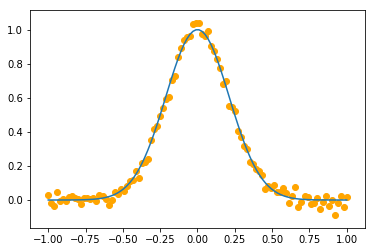

In [2]:
def model_gauss(x, amp, sigma):
    return amp * np.exp(-x**2/sigma**2)

def model_gauss_grad_amp(x, amp, sigma):
    return np.exp(-x**2/sigma**2)

def model_gauss_grad_sigma(x, amp, sigma):
    return 2 * x**2 / sigma**3. * amp * np.exp(-x**2/sigma**2)

SIGMA = 0.3
AMP = 1
    
x = np.linspace(-1,1,100)
data_gauss = model_gauss(x, AMP, SIGMA)
data_gauss += np.random.standard_normal(data_gauss.size) * 0.03

pl.figure(figsize=(6,4))
pl.plot(x, model_gauss(x, AMP, SIGMA))
pl.scatter(x, data_gauss, c='orange')
#pl.plot(x, model_gauss_grad(x, AMP, SIGMA))

https://fr.wikipedia.org/wiki/Algorithme_du_gradient

minimum =  0.07753535239047281


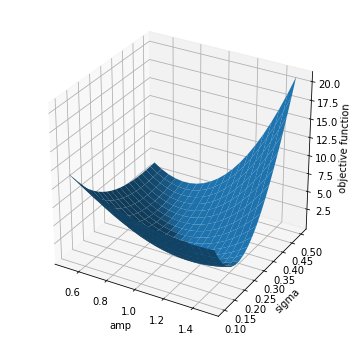

In [14]:
def objective_function(_data, _model, _params):
    return np.nansum((_model(*_params) - _data)**2)

def local_grad(_data, _model, _model_grad, _params):
    # be careful gradient is computed for each parameter independantly
    #if len(_model_grad) != len(_params): raise Exception('the derivative wrt each parameter must be given')
    return np.array([np.nansum(2. * (_model(*_params) - _data) * igrad(*_params)) for igrad in _model_grad])

amps = np.linspace(0.5,1.5,20)
sigmas = np.linspace(0.1, 0.5, 20)

fig = pl.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(amps, sigmas)
zs = np.array([objective_function(data_gauss, model_gauss, [x, iamp, jsigma]) 
               for iamp, jsigma in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('amp')
ax.set_ylabel('sigma')
ax.set_zlabel('objective function')
pl.savefig('objf_gaussian.svg')

print 'minimum = ', np.nanmin(zs)

result:  [0.95 0.31]
number of iterations 85


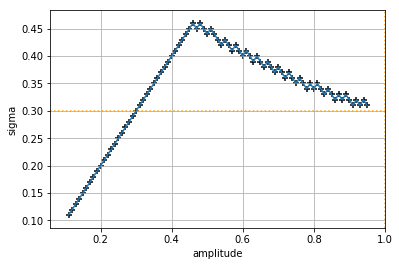

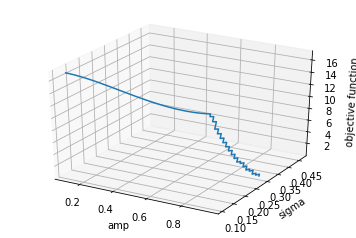

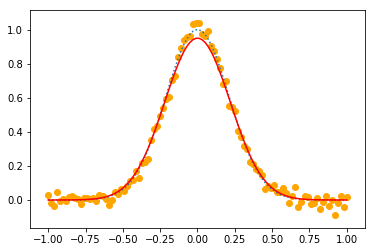

In [4]:
# initial parameters
p_last = (0.1, 0.1)

# iterations step size
LAMBDA_0 = 0.01
OBJECTIVE_FUNCTION_CHANGE_STOP_CONDITION = LAMBDA_0 / 2.
MAX_ITER_LIMIT = 500

last_objval = 1e5
last_grad = np.array((1e5, 1e5))
iterations = list()

# minimization loop
while True:
    params = [x, p_last[0], p_last[1]]
    
    # compute grad
    igrad = local_grad(data_gauss, model_gauss, [model_gauss_grad_amp, model_gauss_grad_sigma], params)
    
    # compute new set of parameters based on the direction of the gradient on both axes
    ip = p_last - LAMBDA_0 * np.array(igrad / np.abs(igrad))
    
    # compute objective function value
    iobjval = objective_function(data_gauss, model_gauss, params)
    
    # adding last iteration to the list of iterations
    iterations.append((ip[0], ip[1], float(iobjval)))
    
    # break if objective function does not change by more than a given threshold
    if np.abs(last_objval - iobjval) < OBJECTIVE_FUNCTION_CHANGE_STOP_CONDITION:
        'objective function change break'
        break
    
    # check if we're coming back to the same point and break (loop detection)
    if len(iterations) > 1:
        if np.any(np.sum(np.abs(np.array(iterations[:-1])[:,:1] - ip),axis=1) == 0): 
            print 'looping iterations break'
            break
            
    if len(iterations) == MAX_ITER_LIMIT: 
        break

    # reset last values
    last_objval = float(iobjval)
    last_grad = np.array(igrad)
    p_last = np.array(ip)
    
print 'result: ', ip
print 'number of iterations', len(iterations)

iterations = np.array(iterations)
pl.figure(figsize=(6,4))
pl.plot(iterations[:,0], iterations[:,1])
pl.scatter(iterations[:,0], iterations[:,1], c='black', marker='+')
pl.axvline(x=AMP, c='orange', ls=':')
pl.axhline(y=SIGMA, c='orange', ls=':')
pl.grid()
pl.xlabel('amplitude')
pl.ylabel('sigma')

fig = pl.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(iterations[:,0], iterations[:,1], iterations[:,2])

ax.set_xlabel('amp')
ax.set_ylabel('sigma')
ax.set_zlabel('objective function')

pl.figure(figsize=(6,4))
pl.plot(x, model_gauss(x, AMP, SIGMA), ls=':')
pl.scatter(x, data_gauss, c='orange')
pl.plot(x, model_gauss(x, ip[0], ip[1]), c='red')




## Objective function of a sinc (non convex optimization)

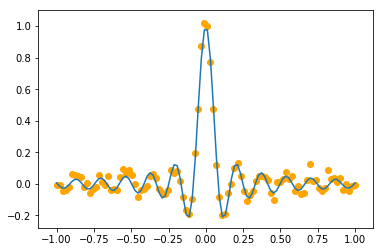

In [5]:
import orb.utils.spectrum

def model_sinc(x, amp, dx):
    return orb.utils.spectrum.sinc1d(x, 0, amp, dx, 0.1)

DX = 0.
AMP = 1
    
x = np.linspace(-1,1,100)
data_sinc = model_sinc(x, AMP, DX)
data_sinc += np.random.standard_normal(data_sinc.size) * 0.03

pl.figure(figsize=(6,4))
pl.plot(x, model_sinc(x, AMP, DX))
pl.scatter(x, data_sinc, c='orange')

### objective function of the amplitude and the position (dx)

minimum =  1.1992309216603931


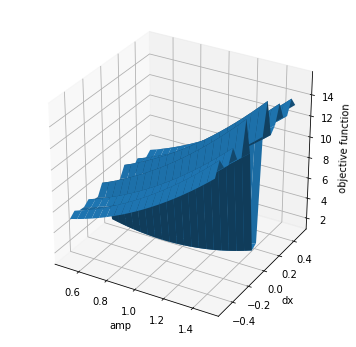

In [33]:
amps = np.linspace(0.5,1.5,20)
dxs = np.linspace(-0.5, 0.5, 20)

fig = pl.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(amps, dxs)
zs = np.array([objective_function(data_sinc, model_sinc, [x, iamp, jdx]) 
               for iamp, jdx in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('amp')
ax.set_ylabel('dx')
ax.set_zlabel('objective function')
ax.view_init(30, -10)
pl.savefig('objf_sinc.svg')
ax.view_init(30, -60)
pl.savefig('objf2_sinc.svg')
print 'minimum = ', np.nanmin(zs)

### objective function of the fwhm and the position (dx)

minimum =  0.2379576412582291


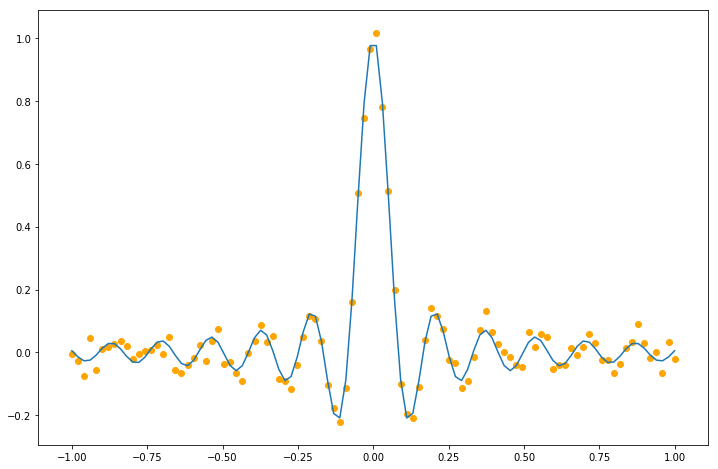

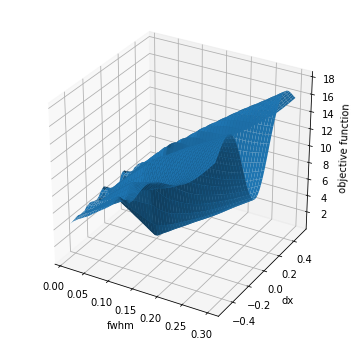

In [7]:
def model_sinc(x, fwhm, dx):
    return orb.utils.spectrum.sinc1d(x, 0, 1, dx, fwhm)

DX = 0.
FWHM = 0.1
    
x = np.linspace(-1,1,100)
data_sinc = model_sinc(x, FWHM, DX)
data_sinc += np.random.standard_normal(data_sinc.size) * 0.03

pl.figure(figsize=(12,8))
pl.plot(x, model_sinc(x, FWHM, DX))
pl.scatter(x, data_sinc, c='orange')

fwhms = np.linspace(0.01, 0.3, 50)
dxs = np.linspace(-0.5, 0.5, 50)

fig = pl.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(fwhms, dxs)
zs = np.array([objective_function(data_sinc, model_sinc, [x, ifwhm, jdx]) 
               for ifwhm, jdx in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('fwhm')
ax.set_ylabel('dx')
ax.set_zlabel('objective function')

print 'minimum = ', np.nanmin(zs)

## Objective function of a gaussian (convex optimization)

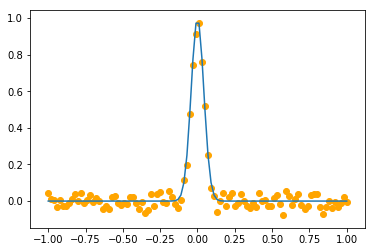

In [16]:
def model_gauss(x, amp, dx):
    return orb.utils.spectrum.gaussian1d(x, 0, amp, dx, 0.1)

DX = 0.
AMP = 1
    
x = np.linspace(-1,1,100)
data_gauss = model_gauss(x, AMP, DX)
data_gauss += np.random.standard_normal(data_gauss.size) * 0.03

pl.figure(figsize=(6,4))
pl.plot(x, model_gauss(x, AMP, DX))
pl.scatter(x, data_gauss, c='orange')

### objective function of the amplitude and the position (dx)

minimum =  0.29262582722612906


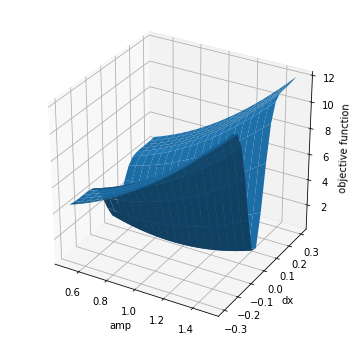

In [34]:
amps = np.linspace(0.5,1.5,20)
dxs = np.linspace(-0.3, 0.3, 20)

fig = pl.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(amps, dxs)
zs = np.array([objective_function(data_gauss, model_gauss, [x, iamp, jdx]) 
               for iamp, jdx in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('amp')
ax.set_ylabel('dx')
ax.set_zlabel('objective function')
ax.view_init(30, -10)
pl.savefig('objf_gauss.svg')
ax.view_init(30, -60)
pl.savefig('objf2_gauss.svg')
print 'minimum = ', np.nanmin(zs)